<a href="https://colab.research.google.com/github/ffalo64/rabbit_challenge/blob/main/4_1_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モジュールのロード

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

# データのロード

In [2]:
tf_flowers = tfds.image_classification.TFFlowers()
tf_flowers.download_and_prepare()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
(train_ds, test_ds) = tf_flowers.as_dataset(as_supervised=True, split=['train[:70%]', 'train[70%:]'], shuffle_files=True)

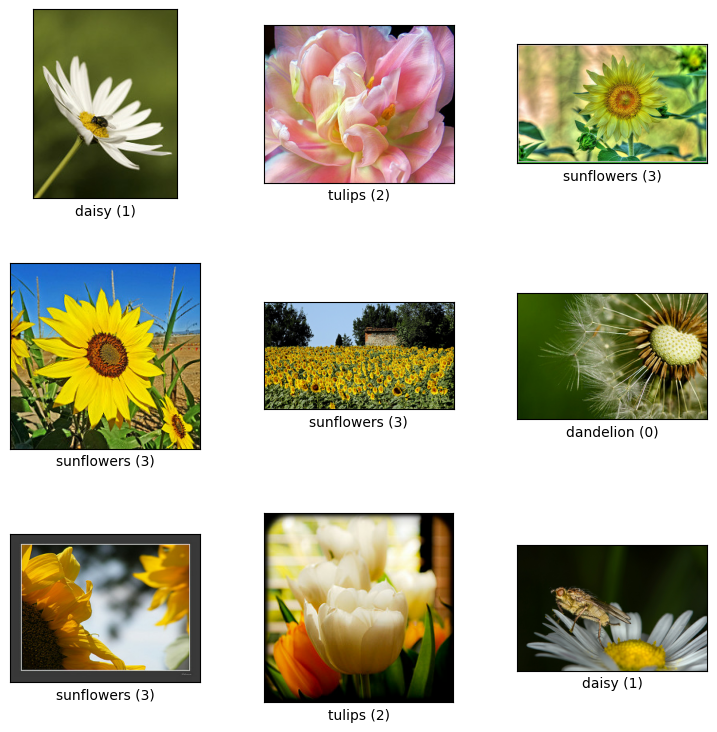

In [4]:
fig = tfds.show_examples(train_ds, tf_flowers.info)

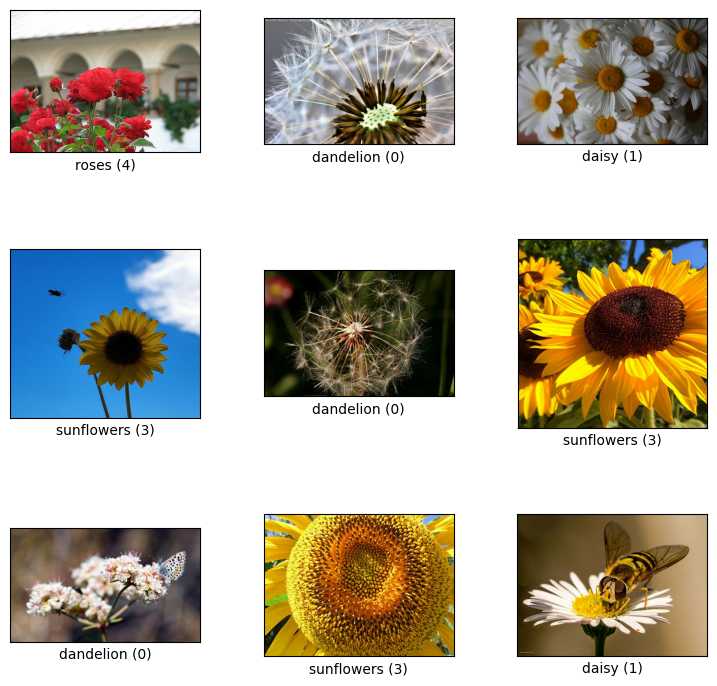

In [5]:
fig = tfds.show_examples(test_ds, tf_flowers.info)

In [6]:
class_num = tf_flowers.info.features['label'].num_classes
class_num

5

In [7]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    label = tf.one_hot(label, depth=class_num)

    return image, label

BATCH_SIZE = 16

train_batches = train_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(test_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


# 事前学習なしでResNetを利用する

In [8]:
resnet = tf.keras.applications.resnet.ResNet50(weights=None)
resnet.trainable = True
x1 = resnet.layers[-2].output # avg_poolまでのoutputを取得します。
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1) # avg_poolから出力層に繋げます。
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
histories = []

In [10]:
EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 [==============================] - 90s 206ms/step - loss: 1.3795 - acc: 0.4515 - val_loss: 6.7881 - val_acc: 0.2352
Epoch 2/20
161/161 [==============================] - 31s 190ms/step - loss: 1.2006 - acc: 0.5146 - val_loss: 6.3390 - val_acc: 0.2352
Epoch 3/20
161/161 [==============================] - 30s 187ms/step - loss: 1.1228 - acc: 0.5516 - val_loss: 2.3048 - val_acc: 0.3052
Epoch 4/20
161/161 [==============================] - 30s 189ms/step - loss: 1.0756 - acc: 0.5800 - val_loss: 1.3771 - val_acc: 0.5368
Epoch 5/20
161/161 [==============================] - 33s 204ms/step - loss: 1.0101 - acc: 0.6104 - val_loss: 2.0074 - val_acc: 0.5114
Epoch 6/20
161/161 [==============================] - 33s 205ms/step - loss: 0.9606 - acc: 0.6310 - val_loss: 2.7881 - val_acc: 0.3261


# ImageNetによる事前学習を利用する(Weightを再利用、事前学習部分は固定)

In [11]:
resnet = tf.keras.applications.resnet.ResNet50(weights='imagenet')
resnet.trainable = False
x1 = resnet.layers[-2].output # avg_poolまでのoutputを取得します。
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1) # avg_poolから出力層に繋げます。
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

102967424/102967424 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [12]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 [==============================] - 16s 80ms/step - loss: 1.6950 - acc: 0.2051 - val_loss: 1.6038 - val_acc: 0.2525
Epoch 2/20
161/161 [==============================] - 12s 73ms/step - loss: 1.5853 - acc: 0.2791 - val_loss: 1.5783 - val_acc: 0.2897
Epoch 3/20
161/161 [==============================] - 12s 74ms/step - loss: 1.5616 - acc: 0.3192 - val_loss: 1.5580 - val_acc: 0.3015
Epoch 4/20
161/161 [==============================] - 12s 75ms/step - loss: 1.5431 - acc: 0.3340 - val_loss: 1.5421 - val_acc: 0.3061
Epoch 5/20
161/161 [==============================] - 12s 73ms/step - loss: 1.5284 - acc: 0.3460 - val_loss: 1.5293 - val_acc: 0.3070
Epoch 6/20
161/161 [==============================] - 14s 85ms/step - loss: 1.5165 - acc: 0.3484 - val_loss: 1.5188 - val_acc: 0.3134
Epoch 7/20
161/161 [==============================] - 14s 85ms/step - loss: 1.5066 - acc: 0.3612 - val_loss: 1.5100 - val_acc: 0.3233
Epoch 8/20
161/161 [==============================] - 14s 85ms

# ImageNetによる事前学習を利用する(ファインチューニングあり)

In [13]:
resnet = tf.keras.applications.resnet.ResNet50(weights='imagenet')
resnet.trainable = True
x1 = resnet.layers[-2].output
out = tf.keras.layers.Dense(class_num, activation='softmax')(x1)
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [14]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches,
                    callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, mode='max')
                    ])
histories.append(history)

Epoch 1/20
161/161 [==============================] - 69s 209ms/step - loss: 0.4561 - acc: 0.8322 - val_loss: 2.2351 - val_acc: 0.2352
Epoch 2/20
161/161 [==============================] - 33s 205ms/step - loss: 0.0561 - acc: 0.9883 - val_loss: 2.5928 - val_acc: 0.2389
Epoch 3/20
161/161 [==============================] - 31s 193ms/step - loss: 0.0103 - acc: 0.9981 - val_loss: 2.6918 - val_acc: 0.3233
Epoch 4/20
161/161 [==============================] - 33s 204ms/step - loss: 0.0113 - acc: 0.9973 - val_loss: 1.0389 - val_acc: 0.7021
Epoch 5/20
161/161 [==============================] - 33s 203ms/step - loss: 0.0031 - acc: 0.9992 - val_loss: 0.3924 - val_acc: 0.8810
Epoch 6/20
161/161 [==============================] - 31s 194ms/step - loss: 5.8577e-04 - acc: 1.0000 - val_loss: 0.2407 - val_acc: 0.9264
Epoch 7/20
161/161 [==============================] - 31s 192ms/step - loss: 3.2945e-04 - acc: 1.0000 - val_loss: 0.1928 - val_acc: 0.9464
Epoch 8/20
161/161 [===========================

# それぞれの学習曲線を確認する

<Axes: xlabel='Epochs', ylabel='acc'>

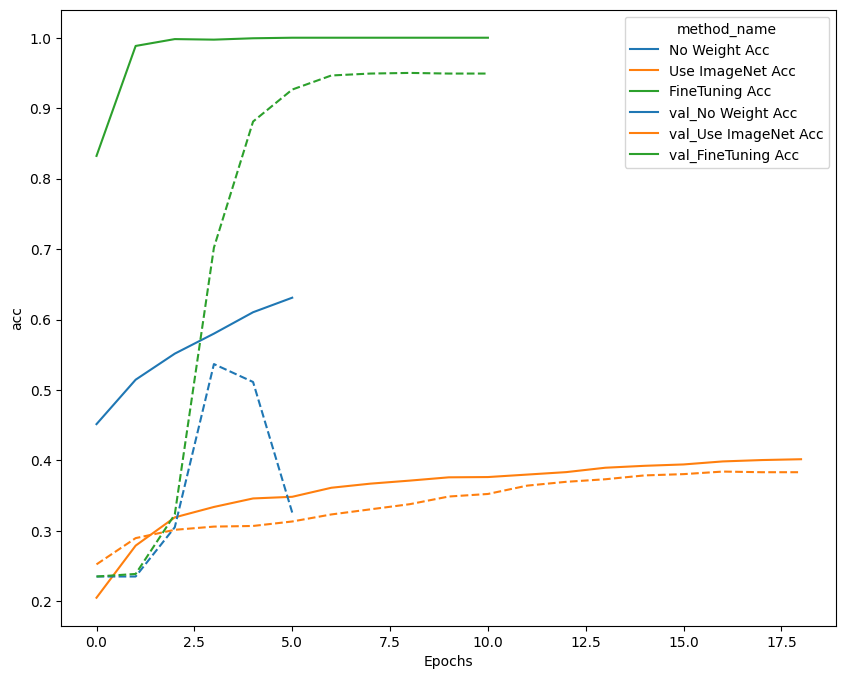

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
method_names = [
                'No Weight Acc',
                'Use ImageNet Acc',
                'FineTuning Acc'
]

plot_df = pd.DataFrame()

for i, history in enumerate(histories):
    method_name = str(method_names[i])
    history_df = pd.DataFrame(history.history)
    history_df['method_name'] = method_name
    history_df['Epochs'] = history_df.index
    plot_df = pd.concat([plot_df, history_df], ignore_index= True)
    
sns.lineplot(data=plot_df, x=plot_df['Epochs'], y='acc', hue='method_name')
val_plot_df = plot_df
val_plot_df['method_name'] = plot_df['method_name'].apply(lambda x: 'val_' + x)
sns.lineplot(data=val_plot_df, x=plot_df['Epochs'], y='val_acc', hue='method_name', linestyle='dashed')